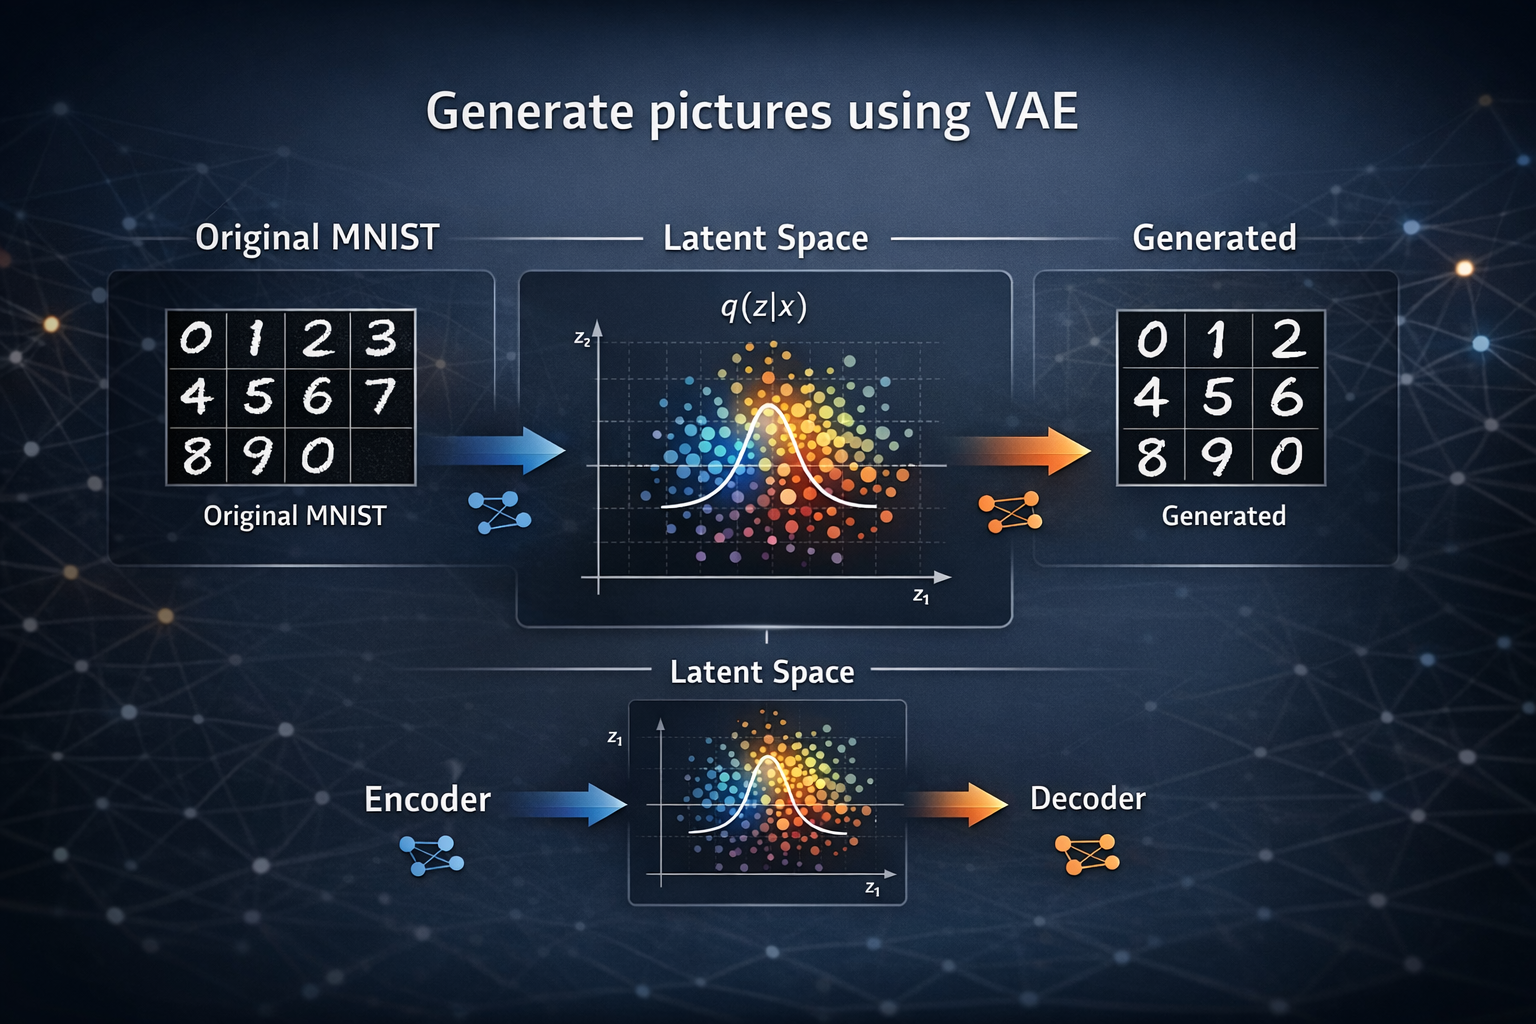

In [16]:
from IPython.display import Image, display
display(Image(filename='/kaggle/input/vae-thumbnail/vae.png'))

# 🧠✨ **Generating Handwritten Digits with Variational AutoEncoders (VAE)**

## 📌 **Introduction**

Generative Artificial Intelligence has rapidly transformed how machines **learn, imagine, and create**.  
One of the most powerful ideas behind modern generative models is the ability to **learn meaningful latent representations** and use them to **generate entirely new data samples**.

In this notebook, we explore **Variational AutoEncoders (VAEs)** — a foundational **deep generative model** — by applying them to the classic **MNIST Handwritten Digit Dataset** 🖊️📊.

---

## 🎯 **Objective of This Notebook**

The main goals of this notebook are:

- 🧠 **Train a Variational AutoEncoder (VAE)** on handwritten digit images  
- 🔢 **Learn a smooth latent space** capable of generating digits from **0 to 9**
- 🎨 **Generate new handwritten digits** by sampling from the latent space  
- 🌫️ **Inject noise into images** and analyze the model’s reconstruction ability  
- 🔍 **Compare clean vs noisy reconstructions** to evaluate robustness  

This project demonstrates how VAEs balance **reconstruction accuracy** and **latent space regularization**, making them a cornerstone of **Generative AI**.

---

## 🏗️ **Why Variational AutoEncoders?**

Unlike traditional autoencoders, VAEs introduce a **probabilistic approach** to representation learning:

- 📦 The encoder maps inputs to a **distribution** instead of fixed points  
- 🎲 Latent variables are **sampled**, enabling diversity in generation  
- 🔗 The latent space becomes **continuous and structured**
- ✨ New data can be generated simply by sampling random vectors  

These properties make VAEs especially useful for:
- Image generation 🖼️  
- Data denoising 🌫️  
- Anomaly detection 🚨  
- Representation learning 🧬  

---

## 🧪 **What You Will See in This Notebook**

By the end of this notebook, you will observe:

- ✅ Smooth training convergence of a VAE model  
- 🎨 Realistic digit generation from random latent samples  
- 🌪️ Effective reconstruction of noisy handwritten digits  
- 📊 Visual comparisons between original, noisy, and reconstructed images  

Each section is designed to build **intuition**, **theory**, and **practical understanding** step by step.

---

## 🚀 **Who Is This Notebook For?**

This notebook is ideal for:

- 📘 Beginners exploring **Generative Models**
- 🤖 Deep Learning enthusiasts interested in **GenAI**
- 🧑‍💻 Data Scientists looking for **practical VAE implementations**
- 🏆 Kaggle learners aiming to build **high-quality, upvote-worthy notebooks**

Let’s dive into the fascinating world of **Variational AutoEncoders** and **generative learning** 🚀✨

---

# ⚙️ **Environment Setup & Required Libraries**

Before building and training our Variational AutoEncoder, we begin by setting up the **deep learning environment** and importing all the necessary libraries.

In this section, we:

- 📦 Import **PyTorch** modules for building and training neural networks  
- 🖼️ Load utilities for handling image datasets and transformations  
- 📊 Import visualization libraries for plotting generated and reconstructed images  
- 🚀 Automatically detect and configure **GPU (CUDA)** support for faster training  

Using GPU acceleration (when available) significantly improves training performance, especially for deep generative models like VAEs.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 📂 **Dataset Loading & Preprocessing**

In this section, we load and prepare the **MNIST Handwritten Digit Dataset**, which contains grayscale images of digits ranging from **0 to 9**.

### 🔹 **Key Steps Performed**

- 🖼️ Convert images into **PyTorch tensors** using `ToTensor()`  
- 📥 Download the dataset automatically if it is not already available  
- 🧪 Separate data into **training** and **testing** sets  
- 📦 Create efficient **DataLoader** objects for batch-wise processing  
- 🔀 Shuffle training data to improve generalization during learning  

The MNIST dataset consists of **28×28 grayscale images**, making it an ideal benchmark for experimenting with **generative models** like Variational AutoEncoders.

Proper preprocessing ensures that the model receives normalized, well-structured input data for stable and efficient training.


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.11MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.46MB/s]


# 🧠 **Variational AutoEncoder (VAE) Architecture**

In this section, we define the architecture of the **Variational AutoEncoder (VAE)** used to model and generate handwritten digits.

Unlike standard autoencoders, a VAE learns a **probabilistic latent representation**, enabling smooth interpolation and meaningful data generation.

---

### 🔹 **Model Components**

### 🧩 **Encoder**
- Flattens the input image (`28×28 → 784`)
- Maps the input into two vectors:
  - **Mean (μ)** of the latent distribution  
  - **Log-variance (log σ²)** of the latent distribution  

These parameters define a **Gaussian distribution** in latent space.

---

### 🎲 **Reparameterization Trick**
To allow backpropagation through stochastic sampling, the VAE uses the **reparameterization trick**:

$$
z = \mu + \sigma \cdot \epsilon,\quad \epsilon \sim \mathcal{N}(0, 1)
$$


This enables stable training while maintaining randomness in latent sampling.

---

### 🔄 **Decoder**
- Takes a latent vector `z`
- Reconstructs the original image dimensions
- Uses a **sigmoid activation** to output pixel values in the range **[0, 1]**

---

### ⚙️ **Forward Pass Overview**
1. Encode the input image into latent distribution parameters  
2. Sample a latent vector using reparameterization  
3. Decode the latent vector to reconstruct the image  

This architecture allows the model to learn both **accurate reconstructions** and a **well-structured latent space**, which is essential for generative tasks.


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 📉 **VAE Loss Function: Reconstruction + KL Divergence**

Training a Variational AutoEncoder requires a carefully designed loss function that balances **image reconstruction quality** and **latent space regularization**.

The total VAE loss is composed of **two key components**:

---

### 🖼️ **1. Reconstruction Loss**

- Measures how well the reconstructed image matches the original input  
- Implemented using **Binary Cross-Entropy (BCE)**  
- Suitable for MNIST since pixel values lie in the range **[0, 1]**

This term encourages the model to produce visually accurate reconstructions.

---

### 🧬 **2. KL Divergence Loss**

- Regularizes the learned latent distribution  
- Forces the latent space to stay close to a **standard normal distribution**  
- Enables smooth interpolation and meaningful sampling  

Mathematically, the KL term is defined as:

$$
\mathrm{KL}\left(q(z|x)\,\|\,\mathcal{N}(0,1)\right)
$$

---

### ⚖️ **Why Combine Both?**

- 🧠 Reconstruction loss alone would cause overfitting  
- 🎯 KL divergence alone would ignore input structure  
- 🔗 Their combination ensures **stable training** and **generative capability**

This combined objective is also known as the **Evidence Lower Bound (ELBO)**, which is fundamental to probabilistic generative models like VAEs.


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction="sum"
    )
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# 🏋️ **Training the Variational AutoEncoder**

In this section, we initialize the VAE model and train it on the MNIST dataset to learn meaningful latent representations of handwritten digits.

---

## 🔧 **Model Configuration**

- 🧠 **Latent Dimension:** 32  
  - Allows the model to learn a richer and more expressive latent space  
- ⚡ **Optimizer:** Adam  
  - Adaptive learning rate for stable and efficient convergence  
- 📉 **Learning Rate:** 0.001  
- 🔁 **Training Epochs:** 20  

---

## 🔄 **Training Process**

For each training epoch:

1. 📦 Input images are **flattened** into vectors of size `784`  
2. 🧠 The VAE performs a **forward pass** (encode → sample → decode)  
3. 📉 The **VAE loss (ELBO)** is computed  
4. 🔙 Gradients are backpropagated through the network  
5. 🚀 Model parameters are updated using Adam optimization  

The training loss printed after each epoch helps monitor **convergence behavior** and ensures stable learning.

---

## 📊 **Expected Outcome**

As training progresses, the loss should:
- Decrease steadily over epochs  
- Stabilize as the latent space becomes well-structured  

This indicates that the model has successfully learned to reconstruct digits while maintaining a smooth and regularized latent distribution.

In [10]:
model = VAE(latent_dim=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for data, _ in train_loader:
        data = data.view(-1, 28*28).to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch [1/20] Loss: 167.4813
Epoch [2/20] Loss: 124.7004
Epoch [3/20] Loss: 116.4299
Epoch [4/20] Loss: 112.6672
Epoch [5/20] Loss: 110.5509
Epoch [6/20] Loss: 109.1715
Epoch [7/20] Loss: 108.1722
Epoch [8/20] Loss: 107.4749
Epoch [9/20] Loss: 106.8714
Epoch [10/20] Loss: 106.4643
Epoch [11/20] Loss: 106.0609
Epoch [12/20] Loss: 105.7432
Epoch [13/20] Loss: 105.4394
Epoch [14/20] Loss: 105.1838
Epoch [15/20] Loss: 104.9939
Epoch [16/20] Loss: 104.8090
Epoch [17/20] Loss: 104.5859
Epoch [18/20] Loss: 104.4520
Epoch [19/20] Loss: 104.2211
Epoch [20/20] Loss: 104.1334


# 🎨 **Generating New Digits from Latent Space**

Now that the VAE has been trained, we can use its decoder to generate new digit images by sampling random vectors from the latent space.

### 🔹 **How Generation Works**
- We sample a random latent vector **z ~ N(0, I)**  
- The decoder maps this latent vector back into image space  
- The output is a generated digit image that resembles MNIST digits  

This demonstrates the **generative power** of VAEs:  
even without any direct input image, the model can produce realistic digit samples.

---

### 🧪 **Generated Samples**
The generated images below represent **random points** in the latent space, showing the diversity and structure learned by the model.


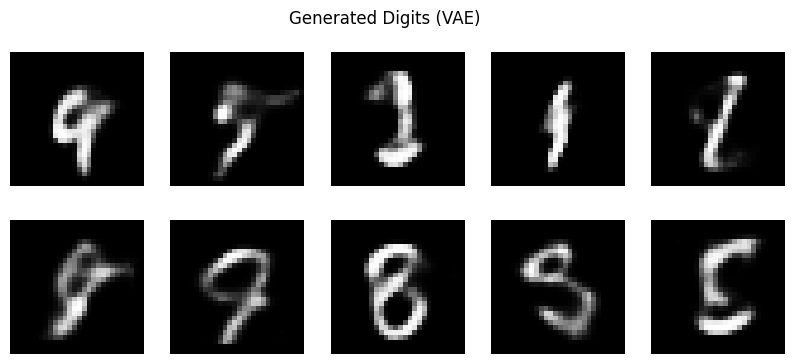

In [12]:
model.eval()

with torch.no_grad():
    z = torch.randn(10, 32).to(device)
    samples = model.decode(z).cpu()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i].view(28,28), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Digits (VAE)")
plt.show()

# 🌪️ **Adding Noise to Images**

To test the robustness of our VAE, we intentionally add random noise to the input images.  
This helps us evaluate whether the model can **denoise and reconstruct** the original digit even when the input is corrupted.

### 🔹 **Noise Function Details**
- Noise is generated using a standard normal distribution  
- The noise intensity is controlled by `noise_factor`  
- We use `torch.clamp()` to keep pixel values within the valid range **[0, 1]**

This step allows us to compare:
- 🧼 Clean reconstruction  
- 🌫️ Noisy reconstruction  
and visually evaluate the model’s denoising ability.


In [13]:
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

# 🔍 **Reconstruction Comparison: Clean vs Noisy Inputs**

In this section, we evaluate the VAE’s ability to reconstruct images under two conditions:

1. **Clean Input**  
   - The original MNIST images are fed into the VAE  
   - Reconstruction is performed normally  

2. **Noisy Input**  
   - Random noise is added to the original images  
   - The noisy images are then passed through the VAE  
   - The model attempts to denoise and reconstruct the digits  

### 🔹 **Why This Matters**
A well-trained VAE should be able to:
- Learn the underlying structure of digits  
- Ignore random noise  
- Produce accurate reconstructions even when the input is corrupted  

This experiment demonstrates the **denoising capability** and robustness of generative models.


In [14]:
model.eval()
data, _ = next(iter(test_loader))
data = data[:8].to(device)

# Original
with torch.no_grad():
    recon_clean, _, _ = model(data.view(-1, 28*28))

# Noisy
noisy_data = add_noise(data)
with torch.no_grad():
    recon_noisy, _, _ = model(noisy_data.view(-1, 28*28))

# 🧪 **Visual Comparison: Original vs Reconstructed vs Noisy Reconstruction**

Now we visualize the results of our experiment by plotting:

- ✅ **Original Images**
- 🧼 **Reconstructed Images (Clean Input)**
- 🌫️ **Reconstructed Images (Noisy Input)**

### 🔹 What to Observe

- **Original**: The ground truth handwritten digit  
- **Recon**: How accurately the VAE can reconstruct the clean input  
- **Noisy Recon**: How well the VAE denoises and reconstructs the corrupted input  

A strong VAE model will show:
- Clear digit shapes in both reconstructions  
- Minimal noise artifacts  
- Good generalization even on noisy inputs  

This comparison helps evaluate the **robustness and generative quality** of the VAE.


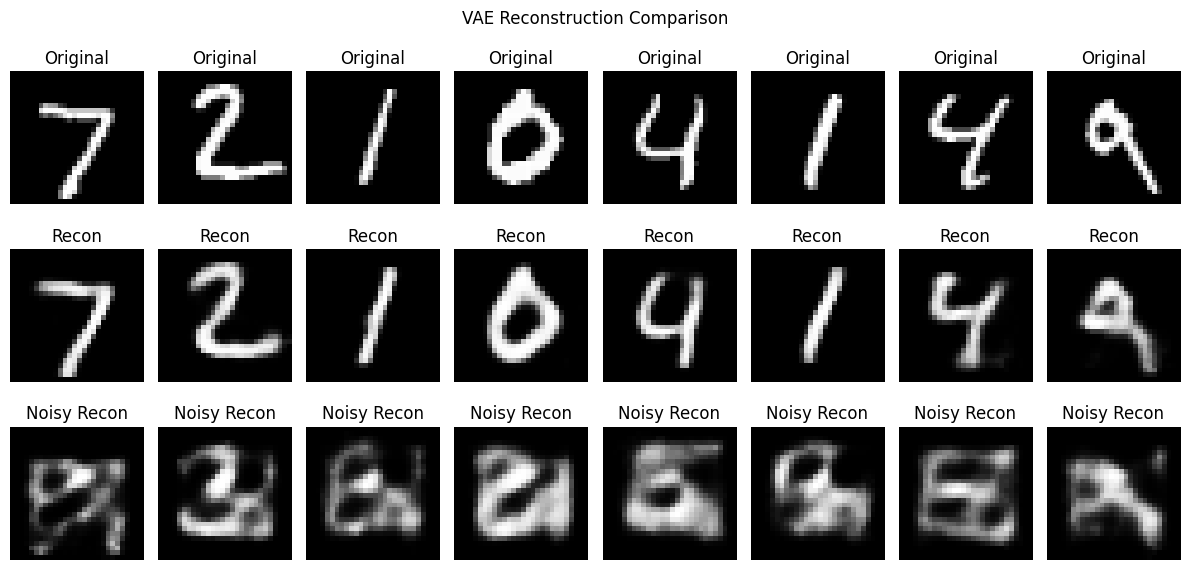

In [15]:
plt.figure(figsize=(12, 6))

for i in range(8):
    # Original
    plt.subplot(3, 8, i+1)
    plt.imshow(data[i].cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Clean Recon
    plt.subplot(3, 8, i+9)
    plt.imshow(recon_clean[i].cpu().view(28,28), cmap="gray")
    plt.title("Recon")
    plt.axis("off")

    # Noisy Recon
    plt.subplot(3, 8, i+17)
    plt.imshow(recon_noisy[i].cpu().view(28,28), cmap="gray")
    plt.title("Noisy Recon")
    plt.axis("off")

plt.suptitle("VAE Reconstruction Comparison")
plt.tight_layout()
plt.show()

## **Thank You!**

Thank you for going through this notebook!  
I hope you found the VAE implementation, digit generation, and noise reconstruction experiments helpful and insightful.

If you enjoyed this work, feel free to:

- 💬 **Leave a comment**
- 🔔 **Follow me for more ML & GenAI projects**
- 🧠 Suggest improvements or request advanced versions (e.g., CVAE, β-VAE, or GANs)

Stay curious and keep building! 🚀
